In [2]:
import pyorc
import cartopy
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
from matplotlib import patches
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from matplotlib.colors import Normalize
from dask.diagnostics import ProgressBar

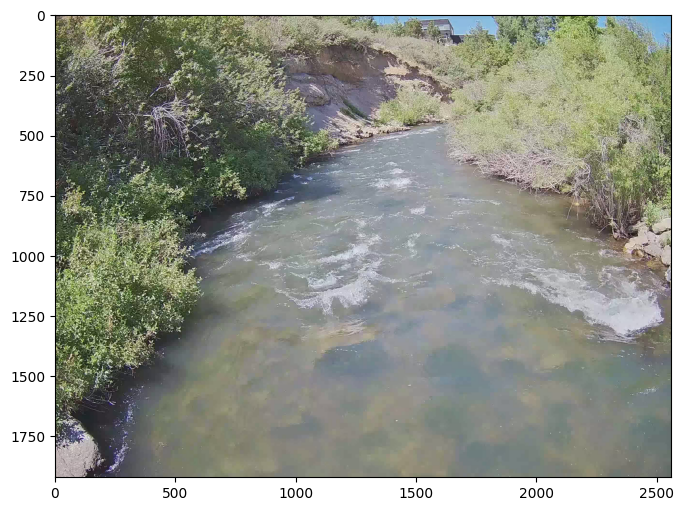

In [3]:
#%matplotlib notebook
# video_file = "waterlab1.mp4"
video_file = "July/videos/video_capture_2024-07-05_10-27-19.mp4"
video = pyorc.api.video.Video(video_file, start_frame=0, end_frame=125)  # we only need one frame
frame = video.get_frame(0, method="rgb")

# plot frame on a notebook-style window
f = plt.figure(figsize=(10, 6))

plt.imshow(frame)

In [ ]:
get_ipython().run_line_magic('matplotlib', 'inline')
gcps = dict(
    src=[
        [2434, 1397], #Blue
        [2304, 1001], #Green
        [525, 879],   #Orange
        [77, 1779]   #Purple
    ]
)

f = plt.figure(figsize=(16, 9))
plt.imshow(frame)
plt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")
plt.legend()
# plt.savefig("control.jpg", bbox_inches="tight", dpi=600)

In [ ]:
# Adding GCPs real word coordinate
gcps["dst"] = [
    [13.633,6.171],  # Blue
    [15.307,9.675],   # Green
    [3.412,15.957],  # Orage
    [5.747,4.855]    # Purple    
]

gcps["z_0"] = 0.00

# set the height and width
height, width = frame.shape[0:2]

# now we use everything to make a camera configuration
cam_config = pyorc.CameraConfig(height=height, width=width, gcps=gcps)

corners = [
    [2375, 975],
    [1925, 750],
    [875, 750],
    [525, 975]
]
cam_config.set_bbox_from_corners(corners)
cam_config.resolution = 0.01
cam_config.window_size = 25

f = plt.figure(figsize=(10, 6))
plt.imshow(frame)
plt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")
plt.plot(*zip(*corners), "co", label="Corners of AOI")
plt.legend()

In [ ]:
get_ipython().run_line_magic('matplotlib', 'inline')
f = plt.figure()
ax2 = plt.axes()
ax2.imshow(frame)
cam_config.plot(ax=ax2, camera=True)

# plt.savefig("ngwerere_camconfig1.jpg", bbox_inches="tight", dpi=600)

In [ ]:
print(cam_config)
# cam_config.to_file("cam-config-UWRL.json")

In [ ]:
cam_config = pyorc.load_camera_config("cam-config-UWRL.json")
cam_config.set_bbox_from_corners(corners)
# set coordinates that encapsulate the water surface at minimum. Areas outside will be used for stabilization
stabilize = [
    [2559, 1919],
    [1752, 680],
    [940, 680],
    [200, 1919]
]
video = pyorc.Video(
    video_file,
    camera_config=cam_config,
    start_frame=0,
    end_frame=125,
    stabilize=stabilize,
    h_a=0.
)
video

In [ ]:
# some keyword arguments for fancy polygon plotting
patch_kwargs = {
    "alpha": 0.5,
    "zorder": 2,
    "edgecolor": "w",
    "label": "Area of interest",
}
f, ax = plt.subplots(1, 1, figsize=(10, 6))

frame = video.get_frame(0, method="rgb")
# plot frame on a notebook-style window
ax.imshow(frame)
# add the polygon to the axes
patch = patches.Polygon(
    stabilize,
    **patch_kwargs
)
p = ax.add_patch(patch)

In [ ]:
da = video.get_frames()
# da

In [ ]:
da[0].frames.plot(cmap="gray", ax=ax)

da_norm = da.frames.normalize()
da_norm[0].frames.plot(cmap="gray")

In [ ]:
f = plt.figure(figsize=(16, 9))
da_norm_proj = da_norm.frames.project()
da_norm_proj[0].frames.plot(cmap="gray")

# extract frames again, but now with rgb
da_rgb = video.get_frames(method="rgb")
# project the rgb frames, same as before
da_rgb_proj = da_rgb.frames.project()

piv = da_norm_proj.frames.get_piv()
delayed_obj = piv.to_netcdf("waterlab_test.nc", compute=False)
with ProgressBar():
    results = delayed_obj.compute()

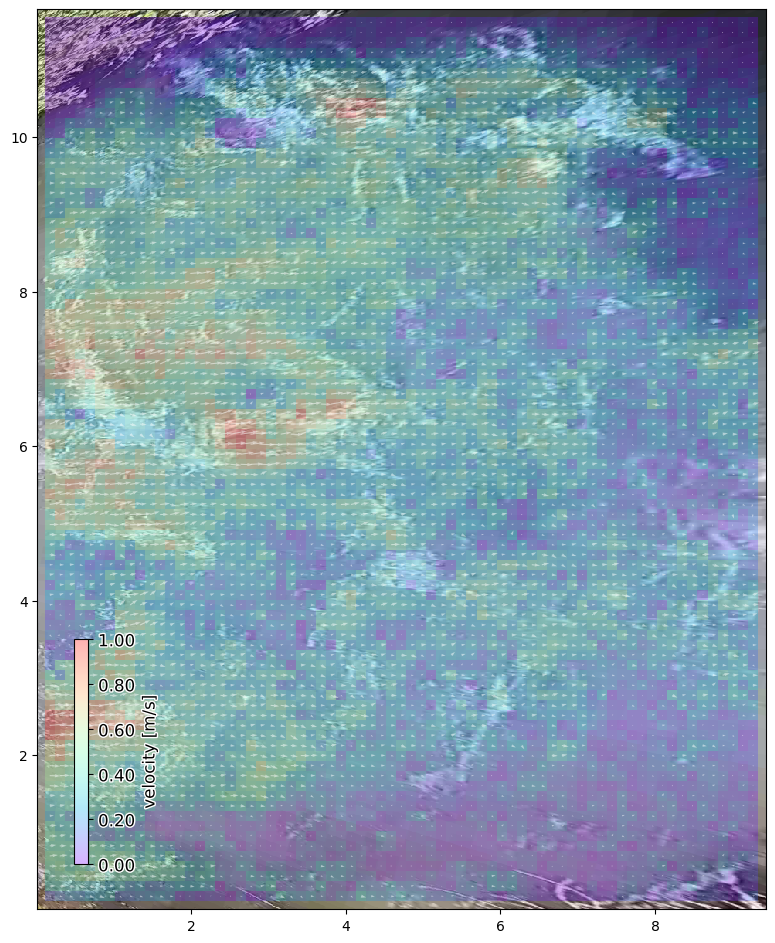

In [4]:
ds = xr.open_dataset("waterlab_test.nc")
ds

video = pyorc.Video(video_file, start_frame=0, end_frame=125)

# borrow the camera config from the velocimetry results
video.camera_config = ds.velocimetry.camera_config

da_rgb = video.get_frames(method="rgb")
# project the rgb frame
da_rgb_proj = da_rgb.frames.project()
# plot the first frame (we only have one) without any arguments, default is to use "local" mode
p = da_rgb_proj[0].frames.plot()

# now plot the results on top, we use the mean, because we cannot plot more than 2 dimensions. 
# Default plotting method is "quiver", but "scatter" or "pcolormesh" is also possible.
# We add a nice colorbar to understand the magnitudes.
# We give the existing axis handle of the mappable returned from .frames.plot to plot on, and use 
# some transparency.
ds_mean = ds.mean(dim="time", keep_attrs=True)

# first a pcolormesh
ds_mean.velocimetry.plot.pcolormesh(
    ax=p.axes,
    alpha=0.3,
    cmap="rainbow",
    add_colorbar=True,
    vmax=1.0
)

ds_mean.velocimetry.plot(
    ax=p.axes,
    color="w",
    alpha=0.5,
    width=0.0015,
)

/home/waterlab/anaconda3/envs/pyorc/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/waterlab/anaconda3/envs/pyorc/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


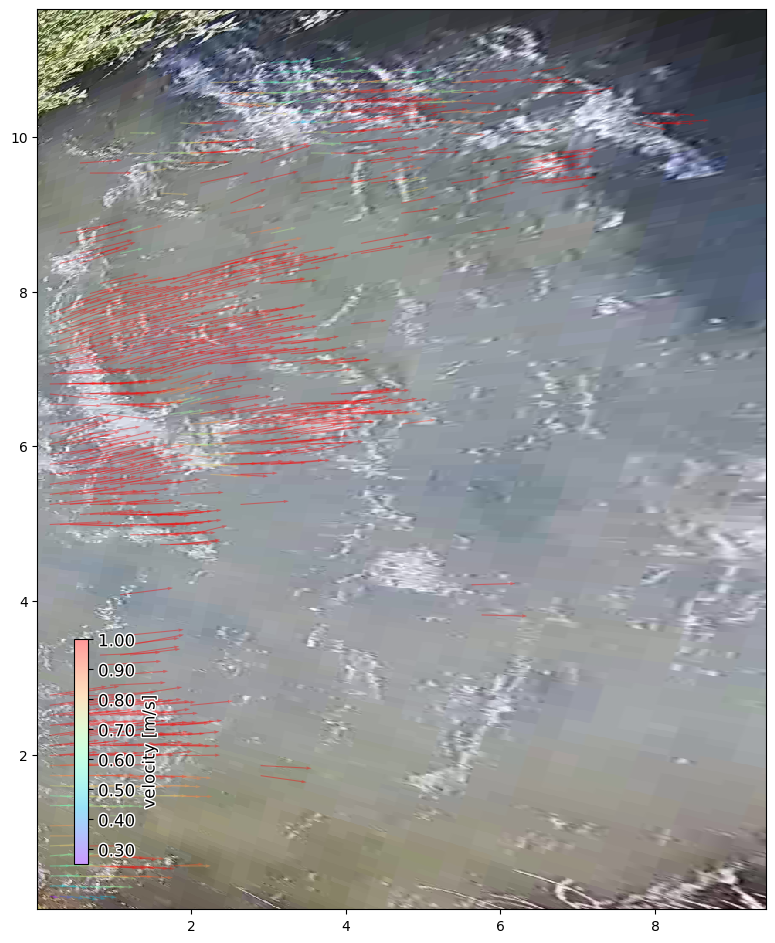

In [5]:
import copy
ds_mask = copy.deepcopy(ds)
mask_corr = ds_mask.velocimetry.mask.corr(inplace=True)
mask_minmax = ds_mask.velocimetry.mask.minmax(inplace=True)
mask_rolling = ds_mask.velocimetry.mask.rolling(inplace=True)
mask_outliers = ds_mask.velocimetry.mask.outliers(inplace=True)
mask_var = ds_mask.velocimetry.mask.variance(inplace=True)
mask_angle = ds_mask.velocimetry.mask.angle(inplace=True)
mask_count = ds_mask.velocimetry.mask.count(inplace=True)

# apply the plot again, let's leave out the scalar values, and make the quivers a bit nicer than before.
ds_mean_mask = ds_mask.mean(dim="time", keep_attrs=True)

# again the rgb frame first
p = da_rgb_proj[0].frames.plot()

#...and then masked velocimetry
ds_mean_mask.velocimetry.plot(
    ax=p.axes,
    alpha=0.4,
    cmap="rainbow",
    scale=20,
    width=0.0015,
    norm=Normalize(vmax=1.0, clip=False),
    add_colorbar=True
)

/home/waterlab/anaconda3/envs/pyorc/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/waterlab/anaconda3/envs/pyorc/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


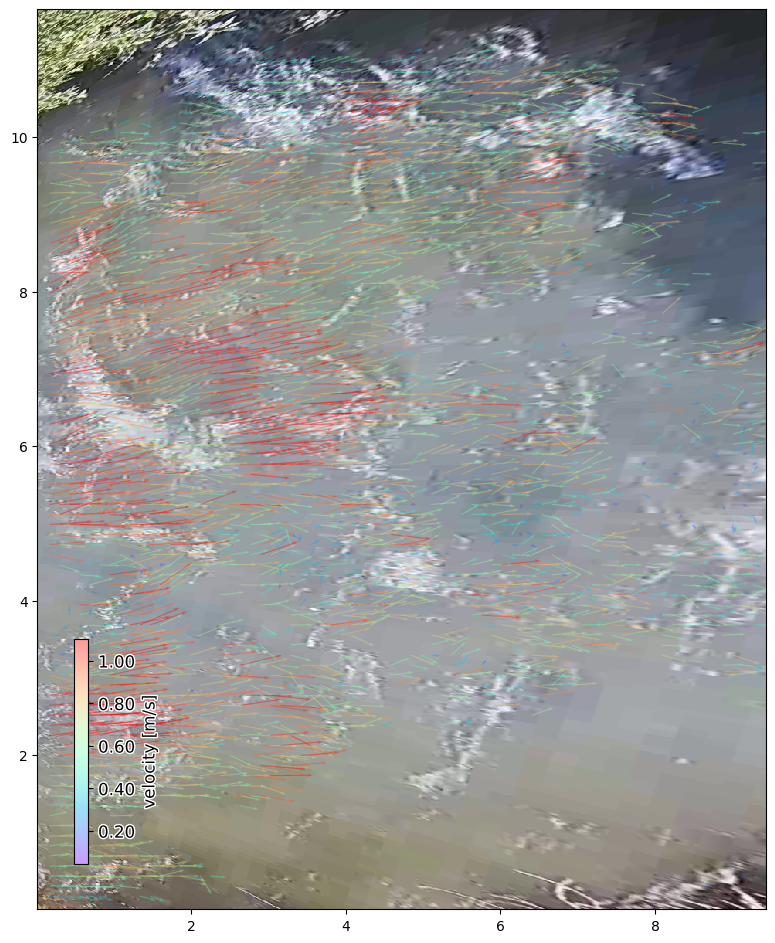

In [6]:
# apply all methods in time domain with relaxed angle masking
import numpy as np
ds_mask2 = copy.deepcopy(ds)
ds_mask2.velocimetry.mask.corr(inplace=True)
ds_mask2.velocimetry.mask.minmax(inplace=True)
ds_mask2.velocimetry.mask.rolling(inplace=True)
ds_mask2.velocimetry.mask.outliers(inplace=True)
ds_mask2.velocimetry.mask.variance(inplace=True)
ds_mask2.velocimetry.mask.angle(angle_tolerance=0.5*np.pi)
ds_mask2.velocimetry.mask.count(inplace=True)
ds_mask2.velocimetry.mask.window_mean(wdw=2, inplace=True, tolerance=0.5, reduce_time=True)

# Now first average in time before applying any filter that only works in space.
ds_mean_mask2 = ds_mask2.mean(dim="time", keep_attrs=True)

# apply the plot again
# again the rgb frame first
p = da_rgb_proj[0].frames.plot()

#...and then filtered velocimetry
ds_mean_mask2.velocimetry.plot(
    ax=p.axes,
    alpha=0.4,
    cmap="rainbow",
    scale=20,
    width=0.0015,
    norm=Normalize(vmax=1.1, clip=False),
    add_colorbar=True
)

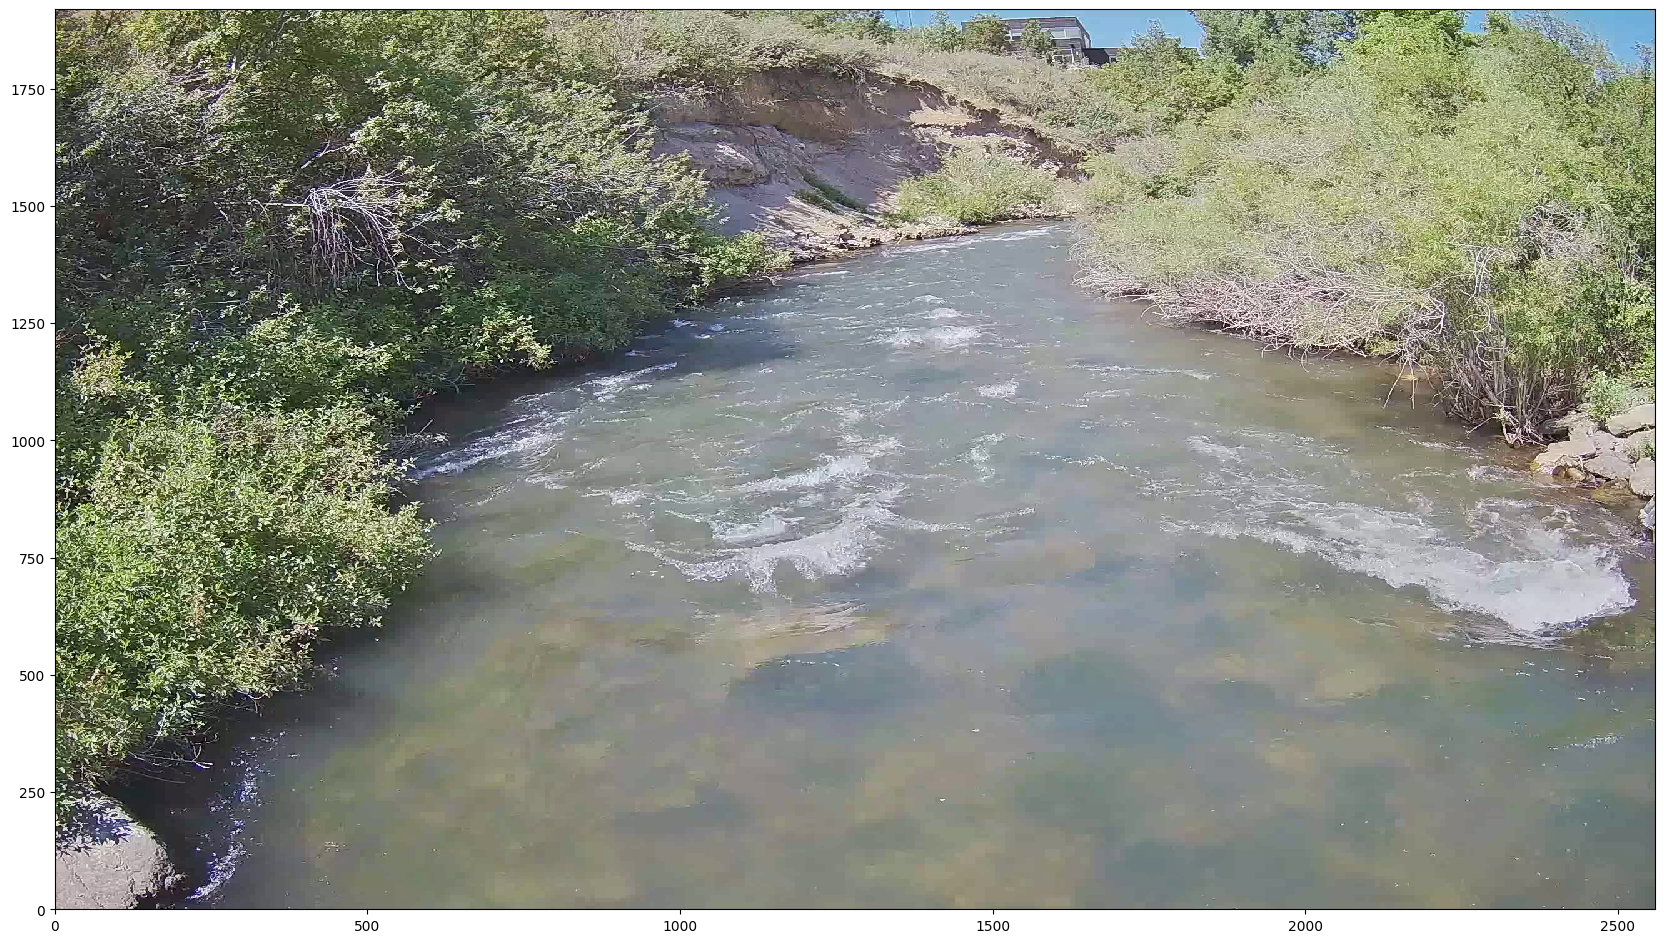

In [7]:
# use the "camera" mode to plot the camera perspective
p = da_rgb[0].frames.plot(mode="camera")

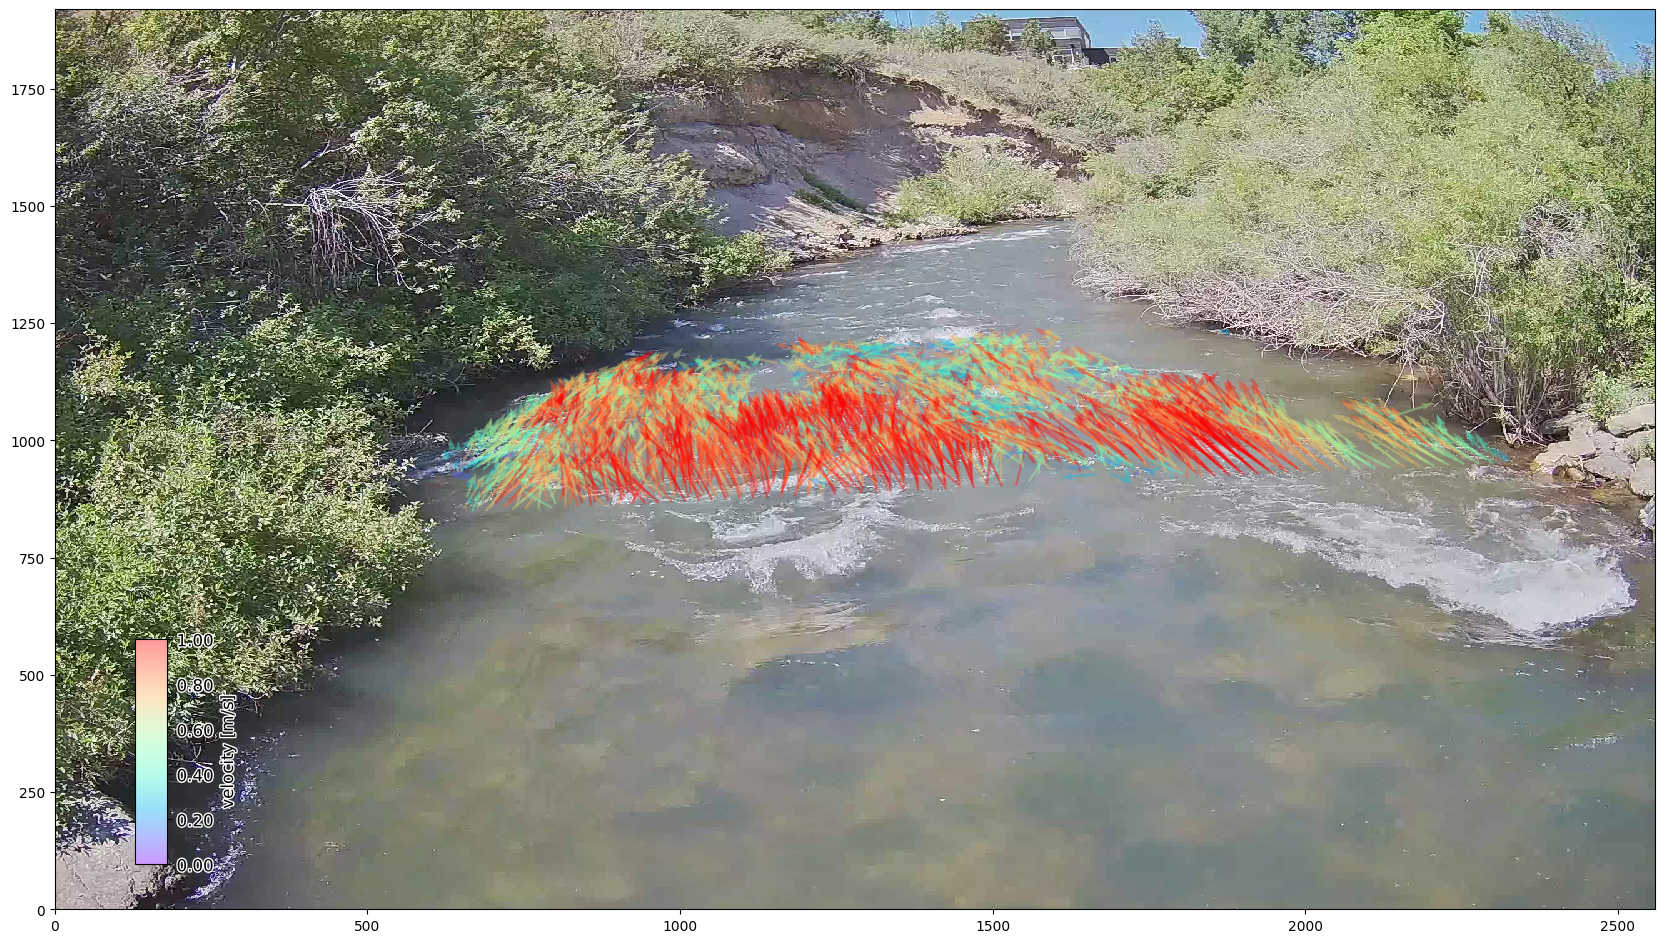

In [8]:
#...and then masked velocimetry again, but also camera. This gives us an augmented reality view. The quiver scale 
# needs to be adapted to fit in the screen properly

p = da_rgb[0].frames.plot(mode="camera")

ds_mean_mask2.velocimetry.plot(
    ax=p.axes,
    mode="camera",
    alpha=0.4,
    cmap="rainbow",
    scale=200,
    width=0.0015,
    norm=Normalize(vmin=0., vmax=1.0, clip=False),
    add_colorbar=True
)

# plt.savefig("feb_t.jpg", bbox_inches="tight", dpi=600)
